In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import ray

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

import lina

pupil_diam = 6.75*u.mm 
lyot_diam = 3.6*u.mm
det_rotation = -7.5 #  degrees of rotation of the detector relative to the optical axis

# The flattest wavefront obtained for the system in the lab by
# performing phase diversity
dm_flat = fits.getdata(scoob.module_path/'scoob_dm_flat.fits')

wavelength_c = 632.8e-9*u.m # central wavelength

nlam = 3
bandwidth = 10/wavelength_c.to_value(u.nm)
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )
print(wavelengths)

npix = 512
oversample = 8

vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)

[6.278e-07 6.328e-07 6.378e-07] m


# Create actors

In [2]:
raySCOOB = ray.remote(scoobpsf.scoob.SCOOBM) # make a ray actor class from the original CGI class  

kwargs = {
    'npsf':256,
    'use_synthetic_opds':True,
    'pupil_diam':pupil_diam,
    'det_rotation':det_rotation,
}

actors = []
for i in range(nlam):
    actors.append(raySCOOB.options(num_cpus=2, num_gpus=1/8).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])

2023-09-13 08:36:28,379	INFO worker.py:1636 -- Started a local Ray instance.


(SCOOBM pid=3579032) Model using synthetic OPD data


ParallelizedScoob Initialized!


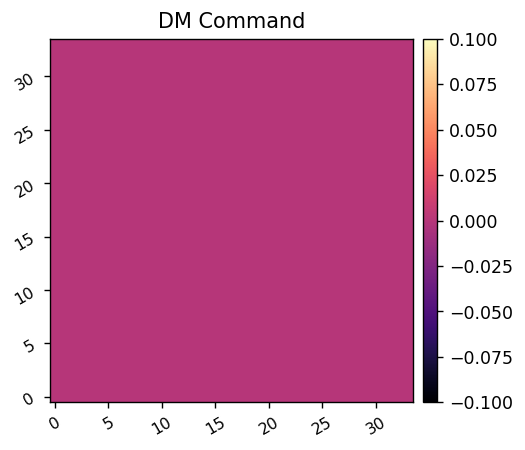

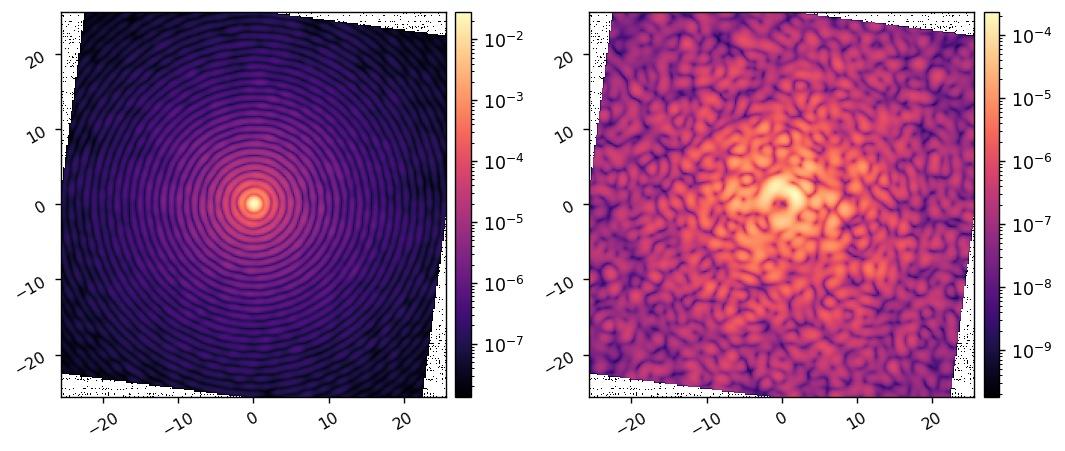

In [5]:
reload(scoobpsf.parascoob)
model = scoobpsf.parascoob.ParallelizedScoob(actors)
model.show_dm()

model.set_actor_attr('FPM', None)
model.set_actor_attr('LYOT', None)
ref_unocc_im = model.snap()

model.Imax_ref = ref_unocc_im.max()
model.normalize = True

model.set_actor_attr('FPM', vortex)
model.set_actor_attr('LYOT', lyot_stop)
ref_im = model.snap()

imshow2(ref_unocc_im, ref_im, lognorm=True, pxscl=model.psf_pixelscale_lamD)

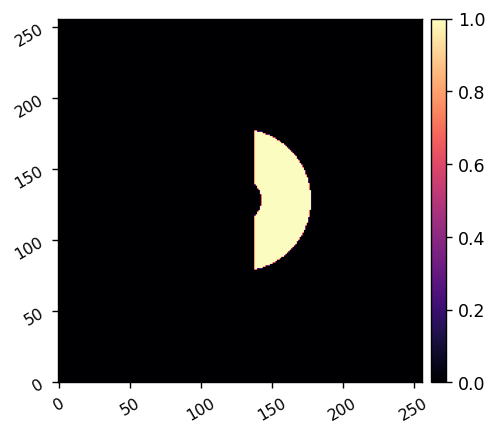

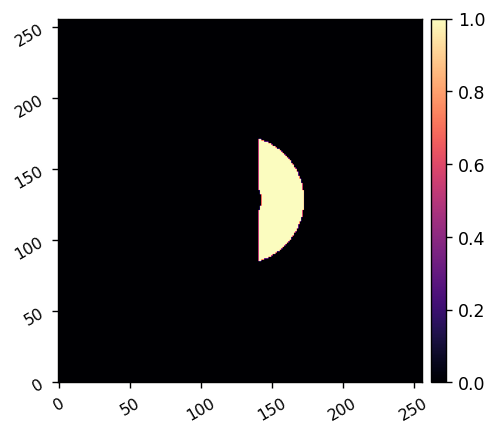

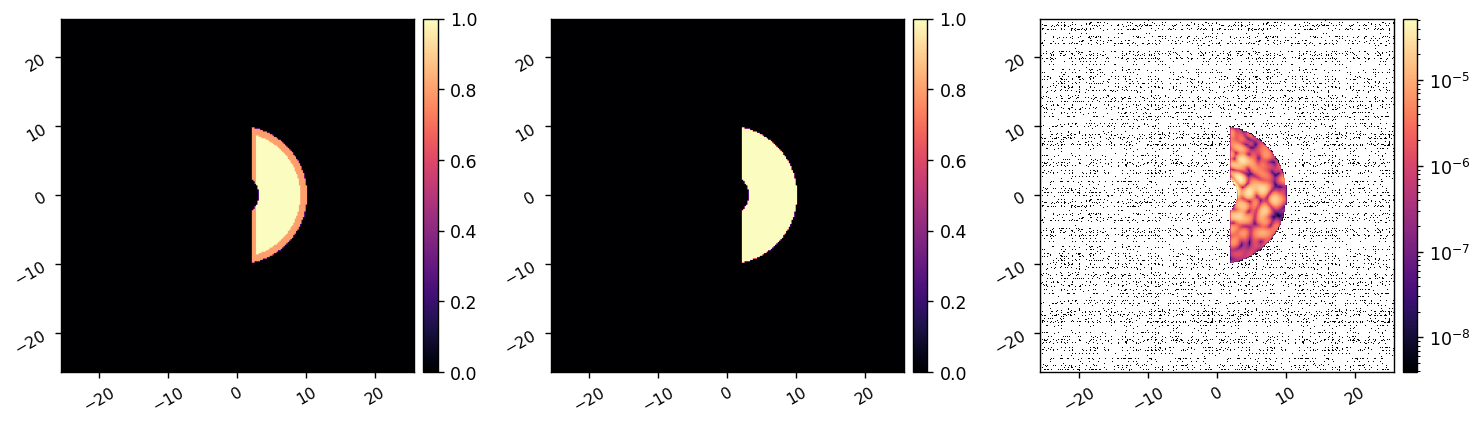

In [6]:
reload(lina.utils)
iwa = 3
owa = 10
edge = 2
roi1 = lina.utils.create_annular_focal_plane_mask(model, iwa, owa, edge=edge, shift=(0,0), rotation=0, plot=True)
roi2 = lina.utils.create_annular_focal_plane_mask(model, iwa, 9, edge=2.5, shift=(0,0), rotation=0, plot=True)

weight_map = 0.8*(roi1 * ~roi2) + roi2
control_mask = weight_map>0
imshow3(weight_map, control_mask, control_mask*ref_im, lognorm3=True, pxscl=model.psf_pixelscale_lamD)

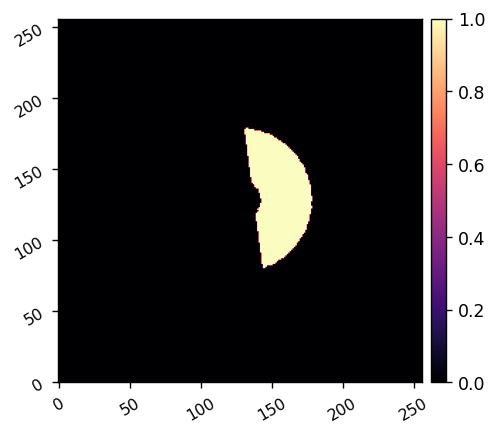

In [7]:
control_mask_for_probes = _scipy.ndimage.rotate(control_mask, model.det_rotation, reshape=False, order=1)
imshow1(control_mask_for_probes)

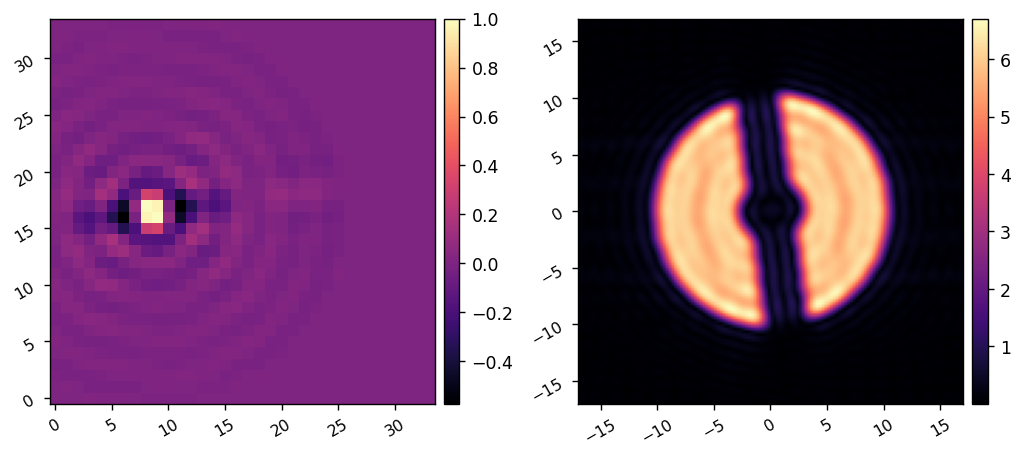

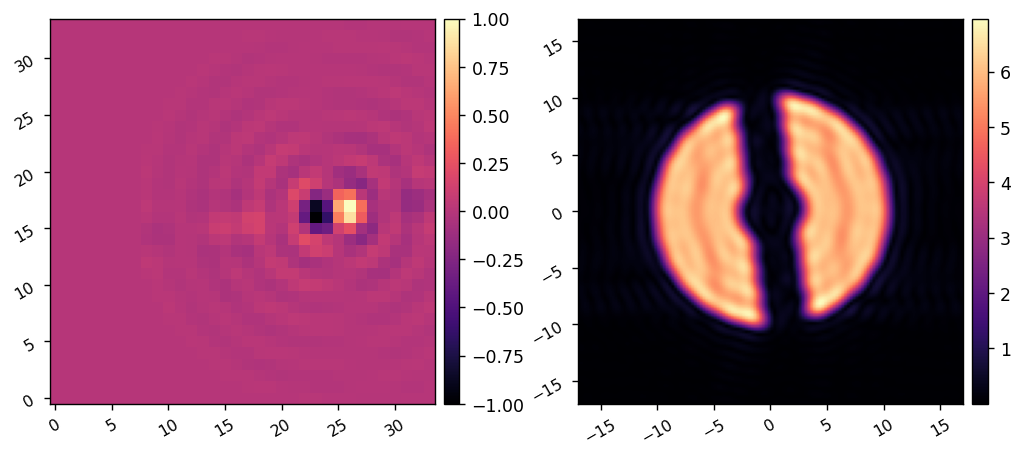

In [8]:
reload(lina.utils)
probe_amp = 2e-8

probe_modes = lina.utils.create_fourier_probes(model, control_mask_for_probes, fourier_sampling=0.2, shift=[(-8,0), (8,0)], nprobes=2, 
                                               plot=True, calc_responses=True)

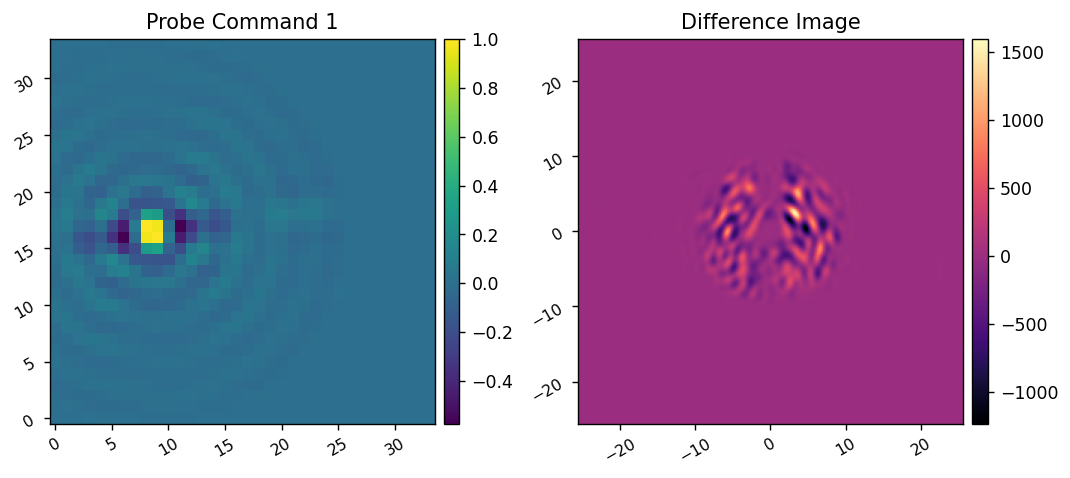

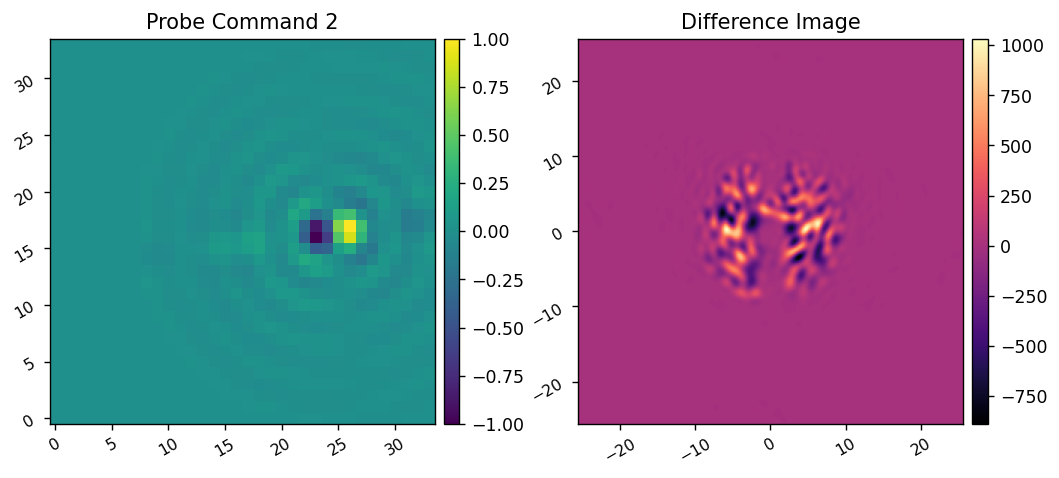

In [9]:
reload(lina.iefc)
model.reset_dm()

differential_images = lina.iefc.take_measurement(model, probe_modes, probe_amp, plot=True)
diff_ims = differential_images.reshape(probe_modes.shape[0], model.npsf, model.npsf)

(234, 1156)


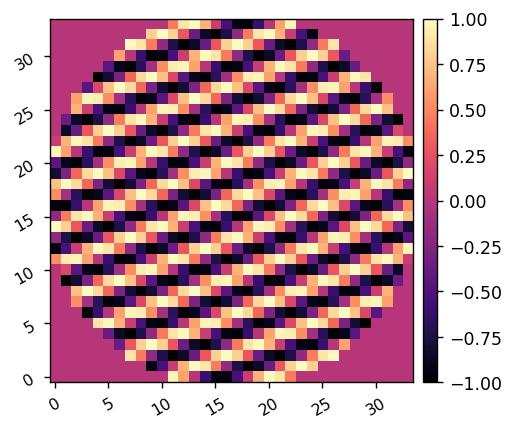

In [10]:
calib_amp = 5e-9
calib_modes = lina.utils.create_fourier_modes(model, control_mask_for_probes, fourier_sampling=1,)
print(calib_modes.shape)

i = 0
imshow1(calib_modes[i].reshape(model.Nact, model.Nact))

(1024, 1156)


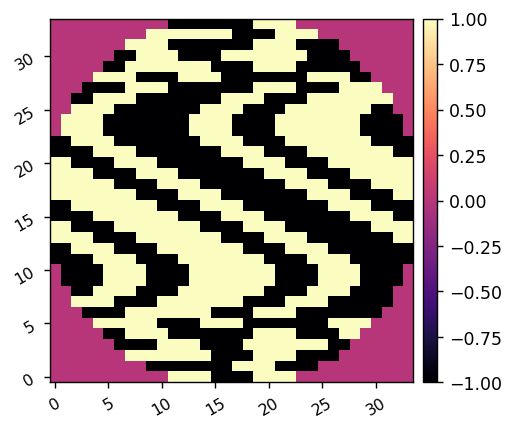

In [11]:
calib_amp = 5e-9
calib_modes = lina.utils.create_hadamard_modes(model.dm_mask)
print(calib_modes.shape)

i = 20
imshow1(calib_modes[i].reshape(model.Nact, model.Nact))

Calibrating iEFC...
	Calibrated mode 254 / 254 in 1873.34s
Calibration complete.


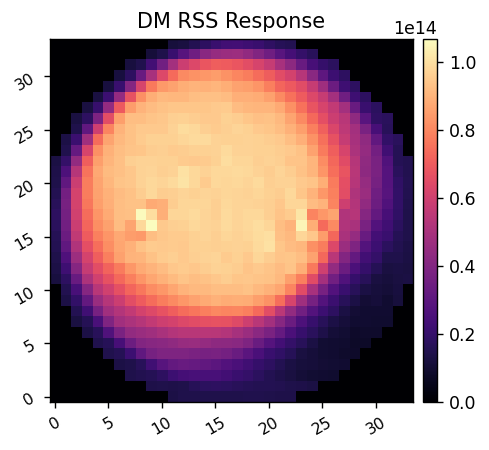

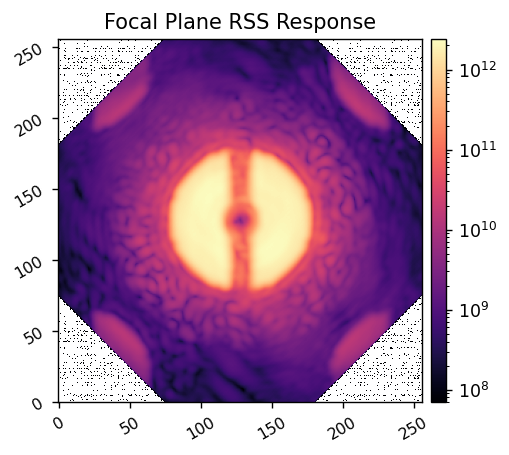

In [10]:
reload(lina.iefc)

model.reset_dm()

response_matrix, response_cube = lina.iefc.calibrate(model, 
                                                     control_mask,
                                                     probe_amp, probe_modes, 
                                                     calib_amp, calib_modes,
                                                     return_all=True, 
                                                     plot_sum=True)

In [21]:
control_matrix = lina.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=probe_modes.shape[0], rcond=1e-3)

(5712, 5712) (5712, 254)


In [12]:
images = xp.array([ref_im])
dm_commands = xp.array([model.get_dm()])

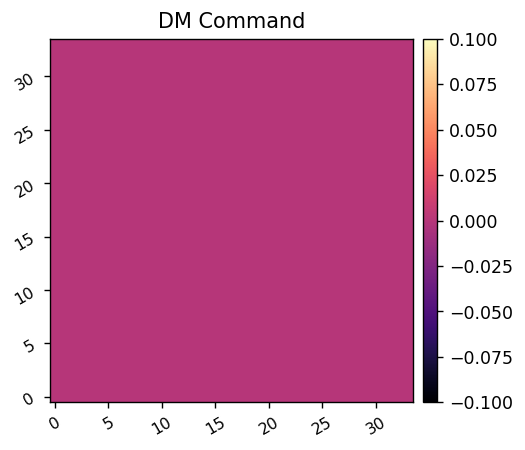

In [13]:
model.reset_dm()
model.show_dm()

Running iEFC...
	Closed-loop iteration 1 / 5
(5712,)
(254, 5712)
	Mean NI of this iteration: 2.015e-08


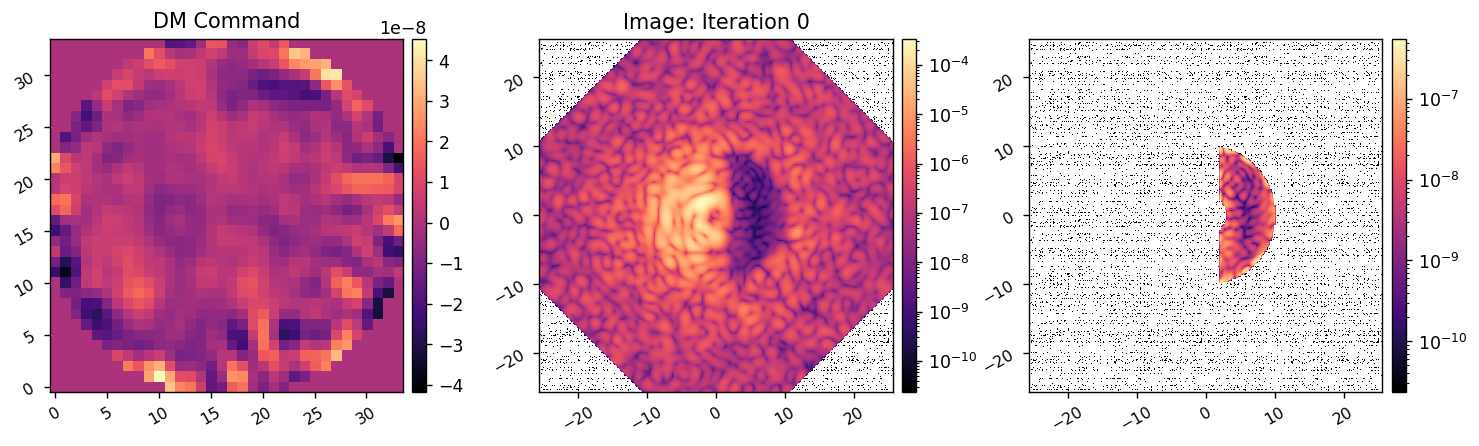

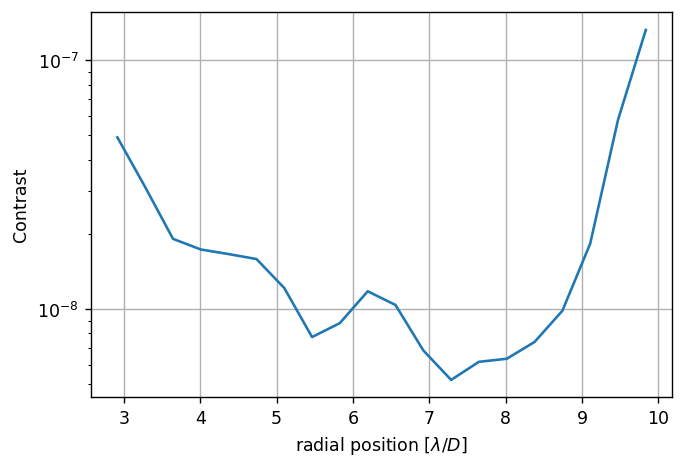

	Closed-loop iteration 2 / 5
(5712,)
(254, 5712)
	Mean NI of this iteration: 2.002e-08


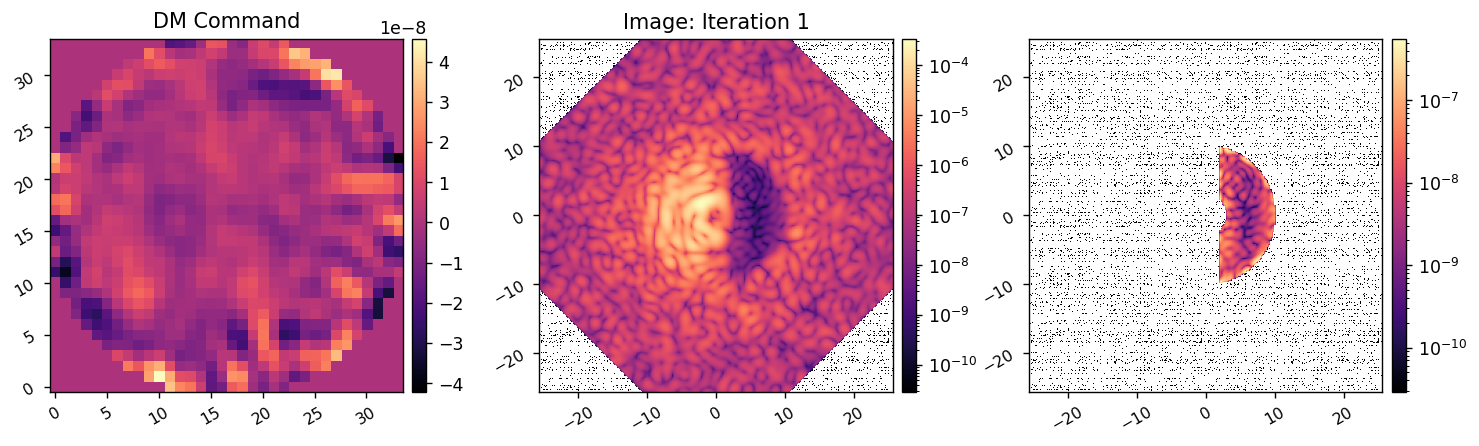

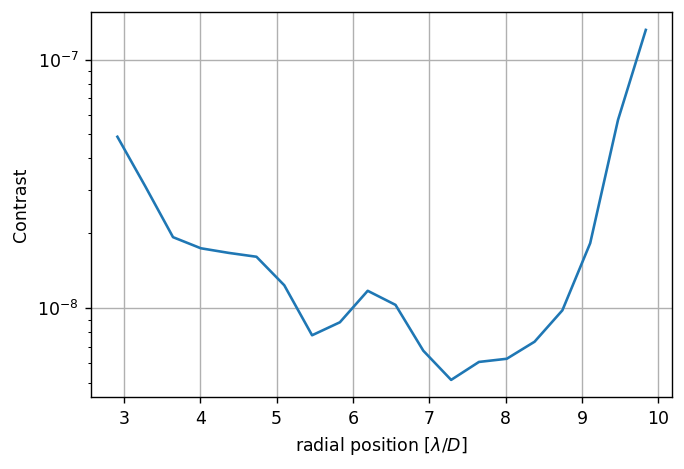

	Closed-loop iteration 3 / 5
(5712,)
(254, 5712)
	Mean NI of this iteration: 1.990e-08


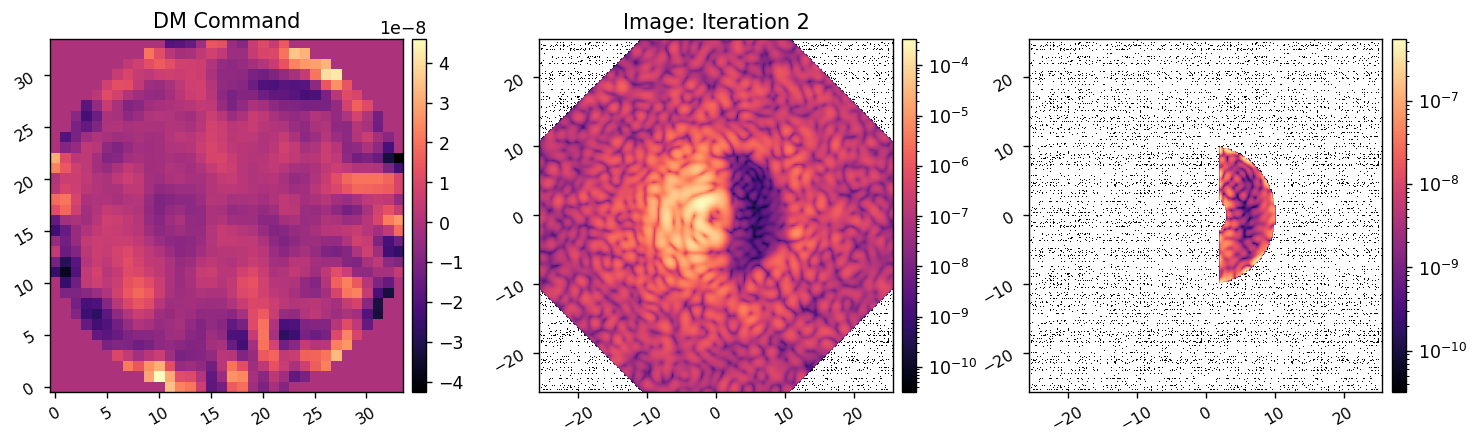

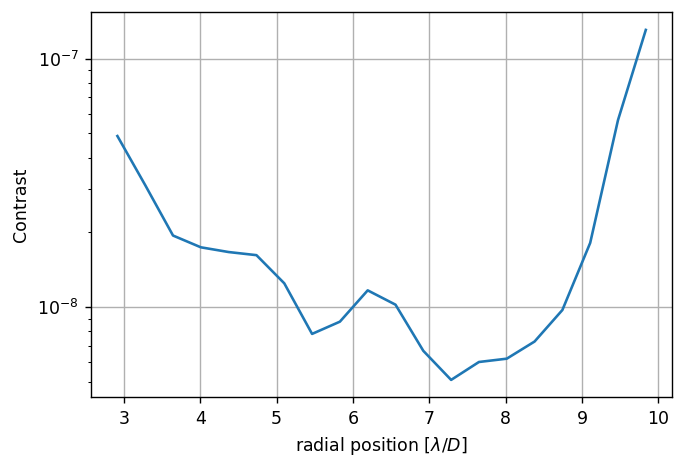

	Closed-loop iteration 4 / 5
(5712,)
(254, 5712)
	Mean NI of this iteration: 1.979e-08


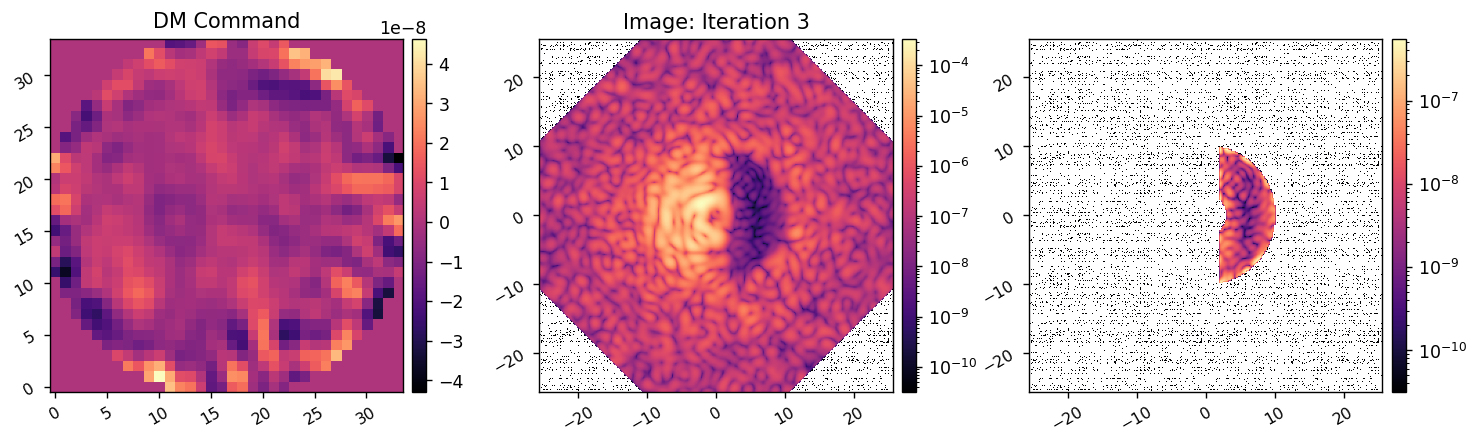

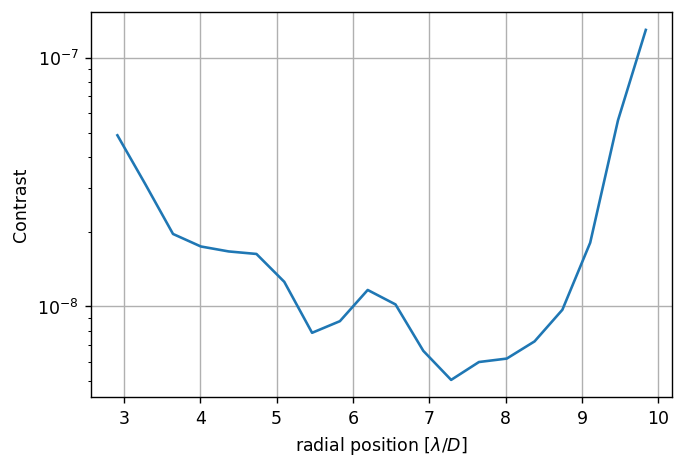

	Closed-loop iteration 5 / 5
(5712,)
(254, 5712)
	Mean NI of this iteration: 1.969e-08


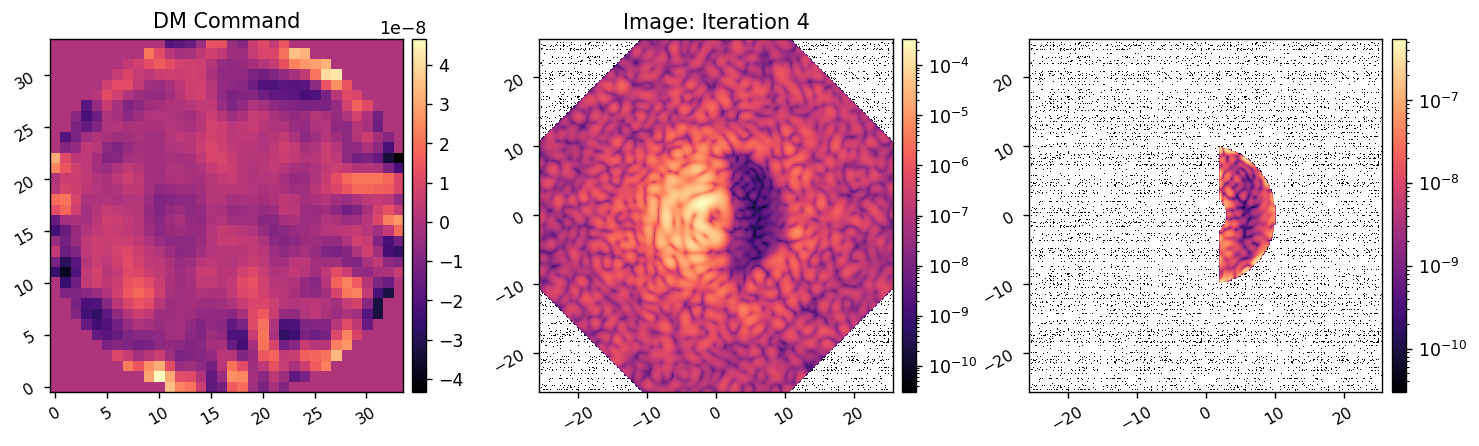

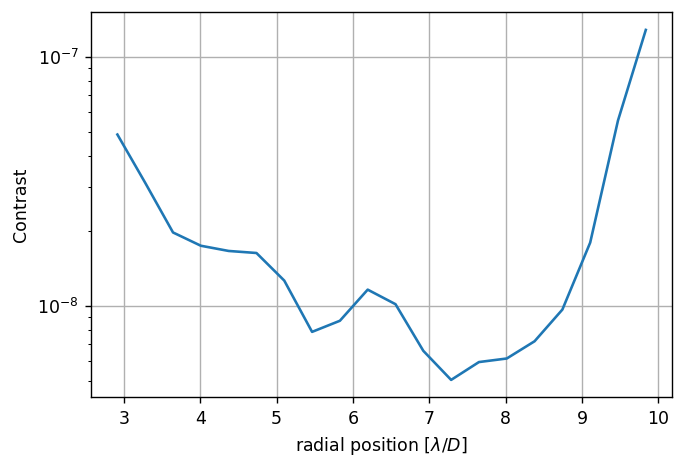

iEFC loop completed in 27.967s.


In [22]:
reload(lina.iefc)
reload(lina.utils)
    
images, dm_commands = lina.iefc.run(model, 
                                      control_matrix,
                                      probe_modes, 
                                      probe_amp, 
                                      calib_modes,
                                      control_mask, 
                                      num_iterations=5, 
                                      loop_gain=0.5, 
                                      leakage=0.0,
                                      plot_all=True,
                                    old_images=images,
                                    old_dm_commands=dm_commands,
                                     )